# Capstone Project

## Introduction



### Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Lib

<a id='item1'></a>

## 1. Download and Explore Dataset

### Download New York data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
#newyork_data

#### The list of neighborhoods are within the *features* key. 
#### Put them in a new variable.

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


#### Fill the dataframe one row at a time.

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = 'GKJTPRRR2GAKPOACEXGOYDD0JBLXHXIPU1VJBHKNMKUWI5LY' # your Foursquare ID
CLIENT_SECRET = 'YLTY20AFU0MMDNL23V1VRSQEN5YOPORSZPG4EMT2SVPMJTPM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GKJTPRRR2GAKPOACEXGOYDD0JBLXHXIPU1VJBHKNMKUWI5LY
CLIENT_SECRET:YLTY20AFU0MMDNL23V1VRSQEN5YOPORSZPG4EMT2SVPMJTPM


##### First neighborhood

In [15]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

# type your answer here
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
#results


Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


<a id='item2'></a>

## 2. Explore Neighborhoods in New York

#### Create a function to get venues for all neighborhoods in Manhattan.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood.

In [17]:
LIMIT = 100
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )



Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [18]:
#print(nyc_venues.shape)
#nyc_venues.groupby('Venue Category').count()

#### Only pull venues that resemble restaurants

In [19]:
drop_categories_1 = ['Pharmacy', 'Gas Station', 'Laundromat', 'Discount Store', 'Mattress Store', 'Grocery Store', 'Baseball Field', 'Bus Station', 'Park', 'Bowling Alley', 'Platform',
                  'Metro Station', 'Convenience Store', 'Intersection', 'Cosmetics Shop', 'Bank', 'Home Service', 'Gym', 'PlayGround', 'Warehouse Store', 'Accessories Store',
                    'Adult Boutique', 'Animal Shelter', 'Antique Shop', 'Arcade', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment', 'Athletics & Sports',
                    'Auditorium', 'Auto Garage', 'Auto Workshop', 'Automotive Shop', 'Baseball Stadium', 'Basketball Court', 'Basketball Stadium', 'Bath House', 'Beach', 'Big Box Store',
                    'Bike Rental / Bike Share', 'Bike Shop', 'Bike Trail', 'Board Shop', 'Boarding House', 'Boat or Ferry', 'Bookstore', 'Boutique', 'Boxing Gym', 'Bridal Shop', 'Bridge',
                    'Building', 'Bus Line', 'Bus Stop', 'Business Center', 'Camera Store', 'Campground', 'Candy Store', 'Cha Chaan Teng', 'Check Cashing Service', 'Cheese Shop', 'Church',
                    'Chocolate Shop', 'Circus', 'Climbing Gym', 'Clothing Store', 'College Academic Building', 'College Art Building', 'College Basketball Court', 'College Bookstore',
                    'College Cafeteria', 'Comedy Club', 'Community Center', 'Concert Hall', 'Construction & Landscaping', 'Cooking School', 'Coworking Space', 'Cycle Studio', 'Dance Studio',
                    'Daycare', 'Department Store', 'Design Studio', 'Doctor\'s Office', 'Dog Run', 'Dosa Place', 'Drugstore', 'Dry Cleaner', 'Duty-free Shop', 'Electronics Store',
                    'Entertainment Service', 'Event Service', 'Event Space', 'Exhibit', 'Eye Doctor', 'Farm', 'Factory', 'Farmers Market', 'Field', 'Film Studio', 'Financial or Legal Service',
                    'Fish Market', 'Flea Market', 'Flower Shop', 'Fountain', 'Fruit & Vegetable Store', 'Furniture / Home Store', 'Gaming Cafe', 'Garden', 'Garden Center', 'General Entertainment',
                    'Gift Shop', 'Golf Course', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym', 'Harbor / Marina', 'Hardware Store', 'Health & Beauty Service', 'Heliport',
                    'Herbs & Spices Store', 'High School', 'Historic Site', 'History Museum', 'Hobby Shop', 'Hostel', 'Hotel', 'Hotel Bar', 'Hotel Pool', 'IT Services', 'Indie Movie Theater',
                    'Indie Theater', 'Jazz Club', 'Jewelry Store', 'Karaoke Bar', 'Kids Store', 'Kitchen Supply Store', 'Lake', 'Laundry Service', 'Lawyer', 'Library', 'Lingerie Store', 
                    'Locksmith', 'Lounge', 'Liquor Store', 'Market', 'Martial Arts Dojo', 'Massage Studio', 'Memorial Site', 'Men\'s Store', 'Mini Golf', 'Miscellaneous Shop', 
                    'Mobile Phone Shop', 'Monument / Landmark', 'Motel', 'Motorcycle Shop', 'Motorsports Shop', 'Movie Theater', 'Moving Target', 'Multiplex', 'Museum', 'Music School',
                    'Music Store', 'Music Venue', 'Nail Salon', 'Neighborhood', 'Nightclub', 'Non-profit', 'Office', 'Opera House', 'Optical Shop', 'Organic Grocery', 'Other Great Outdoors',
                    'Other Nightlife', 'Other Repair Shop', 'Outdoor Sculpture', 'Outdoor Supply Store', 'Outdoors & Recreation', 'Outlet Mall', 'Outlet Store', 'Paper / Office Supplies Store',
                    'Pedestrian Plaza', 'Performing Arts Venue', 'Pet Cafe', 'Pet Service', 'Pet Store', 'Photography Studio', 'Physical Therapist', 'Pier', 'Piercing Parlor', 'Pilates Studio',
                    'Pool', 'Pool Hall', 'Post Office', 'Print Shop', 'Public Art', 'Racetrack', 'Record Shop', 'Recording Studio', 'Recreation Center', 'Rental Car Location', 'Rental Service',
                    'Residential Building (Apartment / Condo)', 'Resort', 'Rest Area', 'River', 'Rock Club', 'Roller Rink', 'Roof Deck', 'Salon / Barbershop', 'Scenic Lookout', 'School', 
                    'Sculpture Garden', 'Shipping Store', 'Shoe Store', 'Shoe Repair', 'Shop & Service', 'Shopping Mall', 'Skate Park', 'Skating Rink', 'Ski Area', 'Smoke Shop', 'Soccer Field',
                    'Social Club', 'Souvlaki Shop', 'Spa', 'Speakeasy', 'Speakeasy', 'Sporting Goods Shop', 'Sports Club', 'State / Provincial Park', 'Storage Facility', 'Street Art', 
                    'Strip Club', 'Supermarket', 'Supplement Shop', 'Surf Spot', 'Tailor Shop', 'Tanning Salon', 'Tattoo Parlor', 'Tea Room', 'Tech Startup', 'Temple', 'Tennis Court',
                    'Tennis Stadium', 'Theater', 'Theme Park', 'Theme Park Ride / Attraction', 'Thrift / Vintage Store', 'Toll Plaza',  'Tourist Information Center', 'Toy / Game Store',
                    'Track', 'Trail', 'Train', 'Train Station', 'Used Bookstore', 'Vape Store', 'Video Game Store', 'Video Store', 'Volleyball Court', 'Waste Facility', 'Waterfront',
                    'Weight Loss Center', 'Women\'s Store', 'Yoga Studio', 'Club House', 'Gay Bar']
attraction_categories = ['Baseball Field', 'Park', 'Bowling Alley','Art Gallery', 'Art Museum','Auditorium','Baseball Stadium', 'Basketball Court', 'Basketball Stadium','Beach',
                    'Circus', 'Comedy Club', 'Concert Hall', 'Exhibit', 'Department Store', 'Fish Market', 'Flea Market', 'Garden', 'General Entertainment', 'Golf Course',
                        'Historic Site', 'History Museum', 'Indie Movie Theater', 'Indie Theater', 'Jazz Club', 'Karaoke Bar', 'Lake', 'Memorial Site', 'Mini Golf', 'Monument / Landmark',
                        'Movie Theater', 'Museum', 'Music Venue', 'Nightclub', 'Opera House', 'Other Nightlife', 'Outdoor Sculpture', 'Outlet Mall', 'Outlet Store', 'Performing Arts Venue',
                        'Pier', 'Pool', 'Pool Hall', 'Public Art', 'Racetrack', 'Rock Club', 'Roller Rink', 'Scenic Lookout', 'Sculpture Garden', 'Shopping Mall',
                        'Skate Park', 'Skating Rink', 'Ski Area', 'Soccer Field', 'Social Club', 'Sports Club', 'State / Provincial Park', 'Street Art', 'Tennis Court', 'Tennis Stadium',
                         'Theater', 'Theme Park', 'Theme Park Ride / Attraction', 'Volleyball Court', 'Waterfront']
hotel_categories = ['Hostel', 'Hotel' 'Hotel Bar', 'Hotel Pool', 'Motel']
other_categories = ['Gym','Boxing Gym','Climbing Gym','Cycle Studio', 'Dance Studio', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym', 
                    'Martial Arts Dojo', 'Pilates Studio', 'Pool', 'Recreation Center', 'Surf Spot','Yoga Studio', 'Business Center',
                   'Bus Station', 'Metro Station', 'Intersection', 'Boat or Ferry', 'Bus Line', 'Bus Stop', 'Train Station']

retaurants = nyc_venues[~nyc_venues['Venue Category'].isin(drop_categories_1)]
attractions = nyc_venues[nyc_venues['Venue Category'].isin(attraction_categories)]
hotels = nyc_venues[nyc_venues['Venue Category'].isin(hotel_categories)]
others = nyc_venues[nyc_venues['Venue Category'].isin(other_categories)]

In [20]:
#retaurants['Venue Category']
#retaurants.groupby('Venue Category').count()
#attractions.groupby('Venue Category').count()
#foot_traffic.groupby('Venue Category').count()
#hotels.groupby('Venue Category').count()
#others.groupby('Venue Category').count()

In [21]:
#foot_traffic.head()
#retaurants.groupby('Neighborhood').count()
#attractions.groupby('Neighborhood').count()
#foot_traffic.groupby('Neighborhood').count()
#hotels.groupby('Neighborhood').count()
#others.groupby('Neighborhood').count()

In [22]:
#print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

## 3. Analyze The Restaurants in Each Neighborhood

#### One Hot Encoding for the Venue Category

In [23]:
# one hot encoding
retaurants_onehot = pd.get_dummies(retaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
retaurants_onehot['Neighborhood'] = retaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [retaurants_onehot.columns[-1]] + list(retaurants_onehot.columns[:-1])
retaurants_onehot = retaurants_onehot[fixed_columns]

#retaurants_onehot.head()

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [24]:
retaurants_grouped = retaurants_onehot.groupby('Neighborhood').mean().reset_index()
#retaurants_grouped

#### Get top 10 most common Restaurants in each neighborhood

#### Function to sort the venues in descending order.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### New dataframe for top 10 Restaurants for each neighborhood.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
#neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
#neighborhoods_venues_sorted['Neighborhood'] = retaurants_grouped['Neighborhood']
restaurants_sorted = pd.DataFrame(columns=columns)
restaurants_sorted['Neighborhood'] = retaurants_grouped['Neighborhood']

for ind in np.arange(retaurants_grouped.shape[0]):
    restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(retaurants_grouped.iloc[ind, :], num_top_venues)

restaurants_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Fast Food Restaurant,Mexican Restaurant,Breakfast Spot,Food,Donut Shop,Dessert Shop,Fried Chicken Joint,Chinese Restaurant
1,Annadale,Pizza Place,Sports Bar,Restaurant,Sushi Restaurant,Diner,American Restaurant,Donut Shop,Ethiopian Restaurant,English Restaurant,Empanada Restaurant
2,Arden Heights,Coffee Shop,Pizza Place,Wings Joint,Dive Bar,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Egyptian Restaurant,Eastern European Restaurant,Dumpling Restaurant
3,Arlington,Coffee Shop,American Restaurant,Deli / Bodega,Wings Joint,Donut Shop,Falafel Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Egyptian Restaurant
4,Arrochar,Italian Restaurant,Deli / Bodega,Mediterranean Restaurant,Pizza Place,Sandwich Place,Middle Eastern Restaurant,Food Truck,Bagel Shop,Polish Restaurant,German Restaurant


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [27]:
# set number of clusters
kclusters = 5

restaurants_grouped_clustering = retaurants_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 4, 2, 3, 2, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
# add clustering labels
restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')


In [29]:
# remove the NaN values
nyc_merged.dropna(subset = ["Cluster Labels"], inplace=True)

nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,2.0,Ice Cream Shop,Sandwich Place,Dessert Shop,Donut Shop,Dive Bar,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Egyptian Restaurant,Eastern European Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,1.0,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Restaurant,Bagel Shop,Dive Bar,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Egyptian Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,0.0,Caribbean Restaurant,Deli / Bodega,Diner,Fast Food Restaurant,Donut Shop,Seafood Restaurant,Juice Bar,Chinese Restaurant,Pizza Place,Czech Restaurant
3,Bronx,Fieldston,40.895437,-73.905643,2.0,Plaza,Wings Joint,Distillery,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Egyptian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
4,Bronx,Riverdale,40.890834,-73.912585,2.0,Plaza,Playground,Medical Supply Store,Food Truck,Wings Joint,Dive Bar,English Restaurant,Empanada Restaurant,Egyptian Restaurant,Eastern European Restaurant


Finally, let's visualize the resulting clusters

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

### Analyze the Attractions spots

#### One Hot Encoding for the Venue Category
#### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [31]:
# one hot encoding
attractions_onehot = pd.get_dummies(attractions[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
attractions_onehot['Neighborhood'] = attractions['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [attractions_onehot.columns[-1]] + list(attractions_onehot.columns[:-1])
attractions_onehot = attractions_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
attractions_grouped = attractions_onehot.groupby('Neighborhood').mean().reset_index()



#### Get top 10 most common Attractions in each neighborhood

In [32]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
attractions_sorted = pd.DataFrame(columns=columns)
attractions_sorted['Neighborhood'] = attractions_grouped['Neighborhood']

for ind in np.arange(attractions_grouped.shape[0]):
    attractions_sorted.iloc[ind, 1:] = return_most_common_venues(attractions_grouped.iloc[ind, :], num_top_venues)
    


#### Run K-means Clustering

In [33]:
# run k-means clustering
attractions_grouped_clustering = attractions_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(attractions_grouped_clustering)

# add clustering labels
attractions_sorted.insert(0, 'Cluster Labels', kmeans.labels_)



#### Merge with the neighborhoods data to get latitude and longitude

In [34]:
nyc_attractions = neighborhoods

nyc_attractions = nyc_attractions.join(attractions_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove the NaN values
nyc_attractions.dropna(subset = ["Cluster Labels"], inplace=True)


#### Visualize on the map

In [35]:

# create map
map_attractions = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_attractions['Latitude'], nyc_attractions['Longitude'], nyc_attractions['Neighborhood'], nyc_attractions['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_attractions)
       
map_attractions

### Analyze Hotels

#### One Hot Encoding for the Venue Category
#### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [36]:
# one hot encoding
hotels_onehot = pd.get_dummies(hotels[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hotels_onehot['Neighborhood'] = hotels['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hotels_onehot.columns[-1]] + list(hotels_onehot.columns[:-1])
hotels_onehot = hotels_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
hotels_grouped = hotels_onehot.groupby('Neighborhood').mean().reset_index()
hotels_grouped

,Neighborhood,Hostel,Hotel Pool,Motel
0,Astoria Heights,1,0,0
1,Bellerose,0,0,1
2,East Williamsburg,1,0,0
3,Long Island City,1,0,0
4,Manhattan Valley,1,0,0
5,Queensbridge,0,1,0


#### Get top 10 most common Hotels in each neighborhood

In [39]:
num_top_venues = 3
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
hotels_sorted = pd.DataFrame(columns=columns)
hotels_sorted['Neighborhood'] = hotels_grouped['Neighborhood']

for ind in np.arange(hotels_grouped.shape[0]):
    hotels_sorted.iloc[ind, 1:] = return_most_common_venues(hotels_grouped.iloc[ind, :], num_top_venues)

#### Run K-means Clustering

In [40]:
# run k-means clustering
hotels_grouped_clustering = hotels_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hotels_grouped_clustering)

# add clustering labels
hotels_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return_n_iter=True)


#### Merge with the neighborhoods data to get latitude and longitude

In [41]:
nyc_hotels = neighborhoods

nyc_hotels = nyc_hotels.join(hotels_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove the NaN values
nyc_hotels.dropna(subset = ["Cluster Labels"], inplace=True)

#### Visualize on the map

In [42]:
# create map
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_hotels['Latitude'], nyc_hotels['Longitude'], nyc_hotels['Neighborhood'], nyc_hotels['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_hotels)
       
map_hotels

### Analyze Others venue categories

#### One Hot Encoding for the Venue Category
#### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [43]:
# one hot encoding
others_onehot = pd.get_dummies(others[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
others_onehot['Neighborhood'] = others['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [others_onehot.columns[-1]] + list(others_onehot.columns[:-1])
others_onehot = others_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
others_grouped = others_onehot.groupby('Neighborhood').mean().reset_index()


#### Get top 10 most common Other Categories in each neighborhood

In [44]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
others_sorted = pd.DataFrame(columns=columns)
others_sorted['Neighborhood'] = others_grouped['Neighborhood']

for ind in np.arange(others_grouped.shape[0]):
    others_sorted.iloc[ind, 1:] = return_most_common_venues(others_grouped.iloc[ind, :], num_top_venues)

#### Run K-means Clustering

In [45]:
# run k-means clustering
others_grouped_clustering = others_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(others_grouped_clustering)

# add clustering labels
others_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Merge with the neighborhoods data to get latitude and longitude

In [46]:
nyc_others = neighborhoods

nyc_others = nyc_others.join(others_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove the NaN values
nyc_others.dropna(subset = ["Cluster Labels"], inplace=True)

#### Visualize on the map

In [47]:
# create map
map_others = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_others['Latitude'], nyc_others['Longitude'], nyc_others['Neighborhood'], nyc_others['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_others)
       
map_others

## Isolate Manhattan


In [48]:
# new dataframe of the Manhattan data.
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

# get the geographical coordinates of Manhattan
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### Get venues in Manhattan

In [49]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Split the vanues into groups

In [50]:

manhattan_restaurants = manhattan_venues[~manhattan_venues['Venue Category'].isin(drop_categories_1)]
manhattan_attractions = manhattan_venues[manhattan_venues['Venue Category'].isin(attraction_categories)]
#manhattan_foot_traffic = manhattan_venues[manhattan_venues['Venue Category'].isin(foot_traffic_categories)]
manhattan_others = manhattan_venues[manhattan_venues['Venue Category'].isin(other_categories)]


### Analyze the restaurants in Manhattan

#### One Hot Encoding for the Venue Category
#### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [51]:
# one hot encoding
manhattan_restaurants_onehot = pd.get_dummies(manhattan_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_restaurants_onehot['Neighborhood'] = manhattan_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_restaurants_onehot.columns[-1]] + list(manhattan_restaurants_onehot.columns[:-1])
manhattan_restaurants_onehot = manhattan_restaurants_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
manhattan_restaurants_grouped = manhattan_restaurants_onehot.groupby('Neighborhood').mean().reset_index()


#### Get top 10 most common Restaurants in each neighborhood

In [52]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
manhattan_restaurants_sorted = pd.DataFrame(columns=columns)
manhattan_restaurants_sorted['Neighborhood'] = manhattan_restaurants_grouped['Neighborhood']

for ind in np.arange(manhattan_restaurants_grouped.shape[0]):
    manhattan_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_restaurants_grouped.iloc[ind, :], num_top_venues)

#### Run K-means Clustering

In [53]:
# set number of clusters
kclusters = 5

# run k-means clustering
manhattan_restaurants_grouped_clustering = manhattan_restaurants_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_restaurants_grouped_clustering)

# add clustering labels
manhattan_restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Merge with the neighborhoods data to get latitude and longitude

In [54]:
nyc_manhattan_restaurants = neighborhoods

nyc_manhattan_restaurants = nyc_manhattan_restaurants.join(manhattan_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove the NaN values
nyc_manhattan_restaurants.dropna(subset = ["Cluster Labels"], inplace=True)

#### Visualize on the map

In [55]:
# create map
map_manhattan_restaurants = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_manhattan_restaurants['Latitude'], nyc_manhattan_restaurants['Longitude'], nyc_manhattan_restaurants['Neighborhood'], nyc_manhattan_restaurants['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_manhattan_restaurants)
       
map_manhattan_restaurants

### Analyze the Attractions in Manhattan

#### One Hot Encoding for the Venue Category
#### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [56]:
# one hot encoding
manhattan_attractions_onehot = pd.get_dummies(manhattan_attractions[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_attractions_onehot['Neighborhood'] = manhattan_attractions['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_attractions_onehot.columns[-1]] + list(manhattan_attractions_onehot.columns[:-1])
manhattan_attractions_onehot = manhattan_attractions_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
manhattan_attractions_grouped = manhattan_attractions_onehot.groupby('Neighborhood').mean().reset_index()


#### Get top 10 most common Attractions in each neighborhood

In [57]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
manhattan_attractions_sorted = pd.DataFrame(columns=columns)
manhattan_attractions_sorted['Neighborhood'] = manhattan_attractions_grouped['Neighborhood']

for ind in np.arange(manhattan_attractions_grouped.shape[0]):
    manhattan_attractions_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_attractions_grouped.iloc[ind, :], num_top_venues)

#### Run K-means Clustering

In [58]:
# run k-means clustering
manhattan_attractions_grouped_clustering = manhattan_attractions_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_attractions_grouped_clustering)

# add clustering labels
manhattan_attractions_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Merge with the neighborhoods data to get latitude and longitude

In [59]:
nyc_manhattan_attractions = neighborhoods

nyc_manhattan_attractions = nyc_manhattan_attractions.join(manhattan_attractions_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove the NaN values
nyc_manhattan_attractions.dropna(subset = ["Cluster Labels"], inplace=True)

#### Visualize on the map

In [60]:
# create map
map_manhattan_attractions = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_manhattan_attractions['Latitude'], nyc_manhattan_attractions['Longitude'], nyc_manhattan_attractions['Neighborhood'], nyc_manhattan_attractions['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_manhattan_attractions)
       
map_manhattan_attractions

### Analyze the Other categories in Manhattan

#### One Hot Encoding for the Venue Category
#### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [61]:
# one hot encoding
manhattan_others_onehot = pd.get_dummies(manhattan_others[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_others_onehot['Neighborhood'] = manhattan_others['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_others_onehot.columns[-1]] + list(manhattan_others_onehot.columns[:-1])
manhattan_others_onehot = manhattan_others_onehot[fixed_columns]

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
manhattan_others_grouped = manhattan_others_onehot.groupby('Neighborhood').mean().reset_index()


#### Get top 10 most common Other categories in each neighborhood

In [62]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
manhattan_others_sorted = pd.DataFrame(columns=columns)
manhattan_others_sorted['Neighborhood'] = manhattan_others_grouped['Neighborhood']

for ind in np.arange(manhattan_others_grouped.shape[0]):
    manhattan_others_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_others_grouped.iloc[ind, :], num_top_venues)

#### Run K-means Clustering

In [63]:
# run k-means clustering
manhattan_others_grouped_clustering = manhattan_others_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_others_grouped_clustering)

# add clustering labels
manhattan_others_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#### Merge with the neighborhoods data to get latitude and longitude

In [64]:
nyc_manhattan_others = neighborhoods

nyc_manhattan_others = nyc_manhattan_others.join(manhattan_others_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove the NaN values
nyc_manhattan_others.dropna(subset = ["Cluster Labels"], inplace=True)

#### Visualize on the map

In [65]:
# create map
map_manhattan_others = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_manhattan_others['Latitude'], nyc_manhattan_others['Longitude'], nyc_manhattan_others['Neighborhood'], nyc_manhattan_others['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_manhattan_others)
       
map_manhattan_others

## Look at the data from a different angle by Plotting Graphs

In [66]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

### Count how many restaurants in each neighborhod and put it on a bar graph

In [67]:
# put the neccessary columns into a new dataframe
df_restaurants = manhattan_restaurants[['Venue Category', 'Neighborhood']].groupby('Neighborhood').count()
df_restaurants.rename(columns={'Venue Category':'Restaurants'}, inplace=True)

df_restaurants.head()

,Restaurants
Neighborhood,
Battery Park City,25
Carnegie Hill,52
Central Harlem,29
Chelsea,40
Chinatown,67


#### Put the data in a bar graph

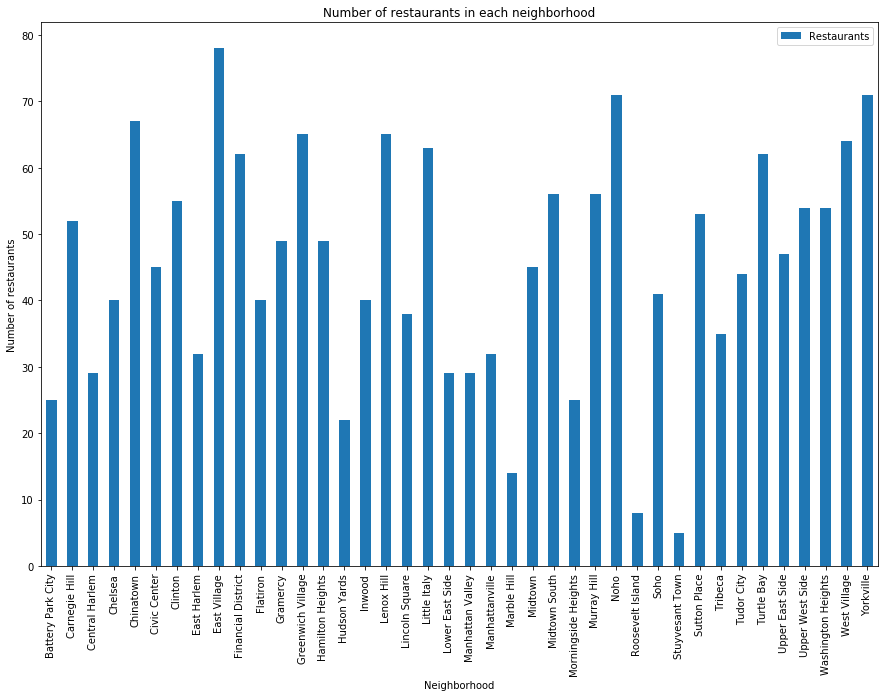

In [68]:
# plot data
df_restaurants.plot(kind='bar', figsize=(15, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Number of restaurants in each neighborhood') # add title to the plot

plt.show()

### Count how many attractions in each neighborhod and put it on a bar graph

In [69]:
# put the neccessary columns into a new dataframe
df_attractions = manhattan_attractions[['Venue Category', 'Neighborhood']].groupby('Neighborhood').count()
df_attractions.rename(columns={'Venue Category':'Attractions'}, inplace=True)
df_attractions.head()

,Attractions
Neighborhood,
Battery Park City,16
Carnegie Hill,2
Central Harlem,5
Chelsea,28
Chinatown,5


#### Put the data in a bar graph

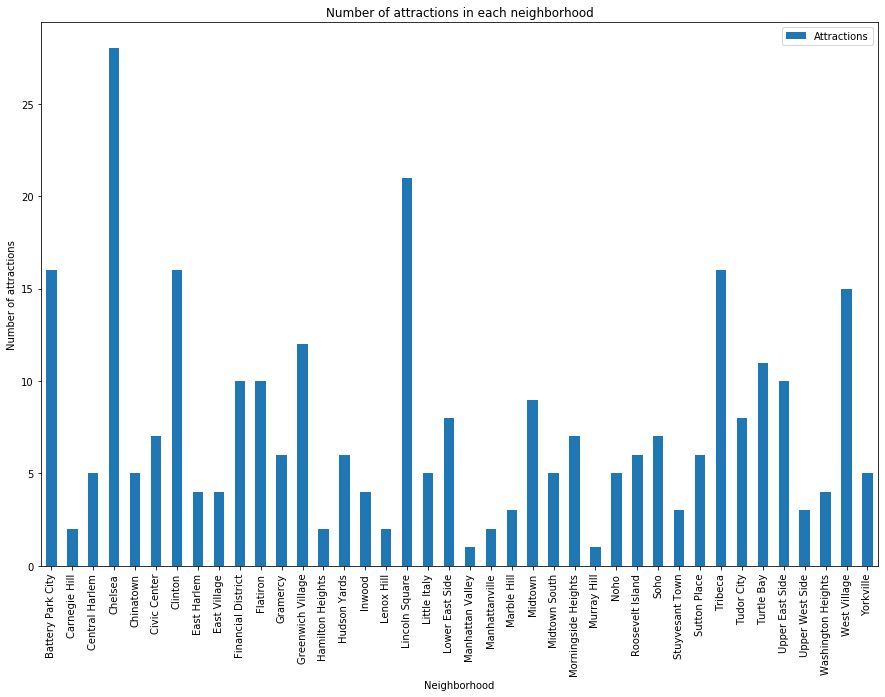

In [70]:
# plot data
df_attractions.plot(kind='bar', figsize=(15, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of attractions') # add y-label to the plot
plt.title('Number of attractions in each neighborhood') # add title to the plot

plt.show()

### Count how many other categories in each neighborhod and put it on a bar graph

In [71]:
# put the neccessary columns into a new dataframe
df_others = manhattan_others[['Venue Category', 'Neighborhood']].groupby('Neighborhood').count()
df_others.rename(columns={'Venue Category':'Others'}, inplace=True)
df_others.head()

,Others
Neighborhood,
Battery Park City,6
Carnegie Hill,11
Central Harlem,3
Chelsea,4
Chinatown,1


#### Put the data in a bar graph

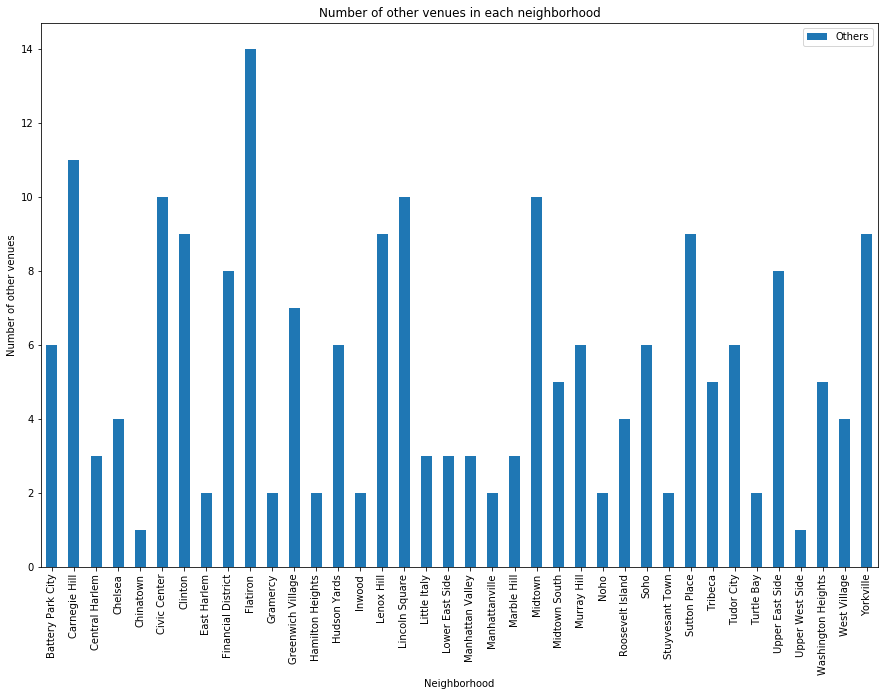

In [72]:
# plot data
df_others.plot(kind='bar', figsize=(15, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of other venues') # add y-label to the plot
plt.title('Number of other venues in each neighborhood') # add title to the plot

plt.show()

## Combine all the graphs to find the best neighborhood

In [73]:
df_join = df_restaurants
df_join = pd.concat([df_join, df_attractions, df_others], axis=1, sort=False)
df_join.head()

,Restaurants,Attractions,Others
Battery Park City,25,16,6.0
Carnegie Hill,52,2,11.0
Central Harlem,29,5,3.0
Chelsea,40,28,4.0
Chinatown,67,5,1.0


#### Replace NaN values with 0

In [74]:
df_join["Others"] = df_join["Others"].fillna(0)

#### Create a Total column of all the venues

In [75]:
df_join['Total'] = df_join.sum(axis=1)
df_total = df_join[['Total']]
df_total.head()

,Total
Battery Park City,47.0
Carnegie Hill,65.0
Central Harlem,37.0
Chelsea,72.0
Chinatown,73.0


#### Plot the total of venues on a graph

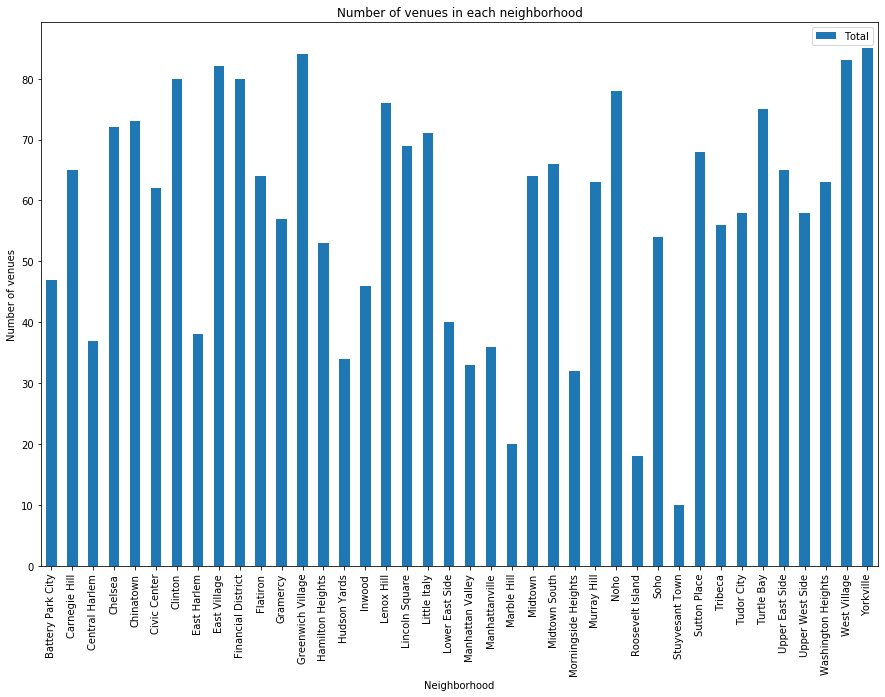

In [76]:
# plot data
df_total.plot(kind='bar', figsize=(15, 10))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of venues in each neighborhood') # add title to the plot

plt.show()
